In [418]:
import numpy as np
import plotly.graph_objects as go
import plotly
import pandas as pd
import plotly.offline as py
from scipy.stats import multivariate_normal as g
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
import time
py.init_notebook_mode(connected=True)

def plot_data(classes, count):
    bar = go.Bar(
        x = classes,
        y = count
    )

    layout = dict(
        title = "Barchart with frequencies",
        xaxis = dict(title = "Classes", type='category'),
        xaxis_tickangle = 45
    )

    fig = go.Figure(data = [bar], layout = layout)
    plotly.offline.iplot(fig)

def plot_traintest(classes, train, test):
    bar1 = go.Bar(
        name = "train",
        x = classes,
        y = train
    )

    bar2 = go.Bar(
        name = "test",
        x = classes,
        y = test
    )

    layout = dict(
        title = "Barchart with frequencies",
        xaxis = dict(title = "Classes", type='category'),
        xaxis_tickangle = 45
    )

    fig = go.Figure(data = [bar1, bar2], layout = layout)
    plotly.offline.iplot(fig)

def print_stats(y_train, X_test, y_test, clf):
    # claculate elapsed time
    elapsed_time = 0.0
    unit = 'min'
    if (end - start) >= 60.0: elapsed_time = (end - start) / 60.0
    else:
        elapsed_time = (end - start)
        unit = 'sec'
    print('Classification time: {:.2f} {:s}\n\n'.format(elapsed_time, unit))

    # roc curve
    metrics.plot_roc_curve(clf, X_test, y_test)  
    plt.show()   

    # macro F1 computation
    acc_test_eval = metrics.f1_score(y_train, ypred_eval, average='macro')
    acc_test_test = metrics.f1_score(y_test, ypred, average='weighted') # weighted because the test dataset is imbalanced

    print("Evaluation F1 score: {:.2f}".format(acc_test_eval))
    print(classification_report(y_train, ypred_eval))

    print("Test F1 score: {:.2f}".format(acc_test_test))
    print(classification_report(y_test, ypred))

def clf_kfold(X_train, y_train, classifier):
    # Split training dataset in 10 folds and keep 1/10 for validation and 9/10 for training
    kf = KFold(n_splits=10, shuffle=False, random_state=None)

    f1_scores_train = []
    f1_scores_validation = []
    i = 0
    best_clf = None
    best_acc = 0.0

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    figroc, ax = plt.subplots()

    start = time.time()
    for train_indx, test_indx in kf.split(X_train):
        Xvalid_train, Xvalid_test = X_train[train_indx], X_train[test_indx]
        yvalid_train, yvalid_test = y_train[train_indx], y_train[test_indx]

        # print('For k = {:d}\n'.format(i+1))

        # fit - predict - evaluate
        # clf = SVC(C=0.1, kernel='linear', random_state=None)
        # clf = GradientBoostingClassifier(max_depth=1)
        # clf = GaussianNB()
        # clf = tree.DecisionTreeClassifier(max_depth=6)
        clf = classifier

        clf.fit(Xvalid_train, yvalid_train)
        ypred_eval = clf.predict(Xvalid_train)
        ypred_valid = clf.predict(Xvalid_test)

        # macro F1 computation
        f1_scores_train.append(metrics.f1_score(yvalid_train, ypred_eval, average='macro'))
        acc_test = metrics.f1_score(yvalid_test, ypred_valid, average='macro')
        f1_scores_validation.append(acc_test)

        # keep the clf with the best performance
        if acc_test > best_acc:
            best_acc = acc_test
            best_clf = clf
            best_scaler = scaler
            best_pca = pca
        
        # confusion matrix structure:
        # -----------
        # | TP | FN |
        # -----------
        # | FP | TN |
        # -----------

        # initialize roc curve
        viz = plot_roc_curve(clf, Xvalid_test, yvalid_test,
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax)
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # print('\nKfold train confusion matrix')
        # print('----------------------------\n')
        # plot_confusion_matrix(clf, Xvalid_train.toarray(), yvalid_train)  
        # plt.show()  
        # print('\nKfold validation confusion matrix')
        # print('-----------------------------------\n')
        # plot_confusion_matrix(clf, Xvalid_test.toarray(), yvalid_test)  
        # plt.show()  
        # print('\n')

        i += 1

    end = time.time()

    # claculate elapsed time
    elapsed_time = 0.0
    unit = 'min'
    if (end - start) >= 60.0: elapsed_time = (end - start) / 60.0
    else:
        elapsed_time = (end - start)
        unit = 'sec'
    print('KFold - classification time: {:.2f} {:s}\n\n'.format(elapsed_time, unit))

    # plot roc curve
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="Receiver operating characteristic curve")
    ax.legend(bbox_to_anchor=(1.65, 0), loc="lower right")
    plt.show()

    # F1 scores
    f1_scores_train = np.array(f1_scores_train)
    print('Kfold train F1')
    print('--------------\n')
    print(f"mean f1: {f1_scores_train.mean():.3f}, sigma f1: {f1_scores_train.std():.3f}, 95% conf: {f1_scores_train.mean()-2*f1_scores_train.std():.3f} - {f1_scores_train.mean()+2*f1_scores_train.std():.3f}")

    f1_scores_validation = np.array(f1_scores_validation)
    print('\nKfold validation F1')
    print('--------------\n')
    print(f"mean f1: {f1_scores_validation.mean():.3f}, sigma f1: {f1_scores_validation.std():.3f}, 95% conf: {f1_scores_validation.mean()-2*f1_scores_validation.std():.3f} - {f1_scores_validation.mean()+2*f1_scores_validation.std():.3f}")

# OLD
# def separate_classes(csv_obj,classno):
#     # Separate features for each class in a dictionary, i.e star type
#     classes = {}    #classes contain every feature for each star type

#     for i in range(classno):
#         classes["".join(str(i))] = []
    
#     for row in csv_obj:
#         featdict = {}
#         for feature in row:
#             if feature != "Star type":
#                 featdict[feature] = row[feature]
#         classes[row['Star type']].append(featdict)
    
#     return classes

# def frequencies(clss):
#     # Find frequencies of feature vectors for each class
#     freqs = {}
#     for c in classes:
#        freqs[c] = len(classes[c])
    
#     return freqs

# def pdf(feature, type):
#     # Prepare plots for pdf of each class for selected feature
#     plots = []
#     color = ['(255, 0, 0','(0, 255, 0','(0, 0, 255','(231, 255, 92','(188, 0, 255','(0, 211, 255']

#     for cl in classes:
#         featlist = None
#         if type == 'int': featlist = [int(x[feature]) for x in classes[cl]]
#         elif type == 'float': featlist = [float(x[feature]) for x in classes[cl]]
#         else: featlist = [x[feature] for x in classes[cl]]

#         x1 = np.array(featlist)
#         xspace = np.linspace(x1.min(), x1.max())
#         yspace1 = g.pdf(xspace, mean=x1.mean(),cov=x1.std())

#         cr = color.pop()
#         plots.append(go.Scatter(x=xspace, y=yspace1, name="p(x|y=)".join(cl), marker_color='rgba'+cr+', .9)'))
    
#     return plots

# with open("../6_class_csv.csv","r") as csvf:
#     csvreader = csv.DictReader(csvf)    #read csv as a dictionary
    
#     classes = separate_classes(csvreader,6)
#     freqs = frequencies(classes)
    
#     # Perform GDA
#     # plots = pdf('Temperature (K)', 'int')
#     # layout = go.Layout(title='Star samples GE for p(x|y)', xaxis=dict(title='x'), yaxis=dict(title='p(x|y)'))
#     # fig = go.Figure(data=plots, layout=layout)
#     # plotly.offline.iplot(fig)

#     x1 = np.array([int(x['Temperature (K)']) for x in classes['0']])
#     xspace = np.linspace(x1.min(), x1.max())
#     yspace1 = g.pdf(xspace, mean=x1.mean(),cov=x1.std())

#     fig = go.Figure(data=[
#         go.Scatter(x=xspace, y=yspace1, name="p(x|y=)".join('0'), marker_color='rgba(44, 193, 93, .9)')
#     ])

#     plotly.offline.iplot(fig)

## Data inspection

In [376]:
print('Reading csv file...\n')
df = pd.read_csv('../mbti_full_pull.csv') # read data from csv
print(df.info()) # print dataframe info

Reading csv file...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1794016 entries, 0 to 1794015
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   author_flair_text  object
 1   body               object
 2   subreddit          object
dtypes: object(3)
memory usage: 41.1+ MB
None


In [377]:
print(df.head()) # take a look at the content

  author_flair_text                                               body  \
0              INTJ  Knowing you're in INTJ is a tool for you to us...   
1              INTJ           You are truly an enlightened mastermind.   
2         INFJ, 26F  You should :) it will help if you have a down ...   
3              INTP  I watch a bit of everything (including hentai)...   
4              INTJ  I don't know if I would count this as a pet pe...   

  subreddit  
0      intj  
1      intj  
2      infj  
3      INTP  
4      intj  


We can see that there are 3 columns, author's description(author_flair_text), the main post texts(body) and the  
subreddit which could be used to extract the labels

## Preprocess data

Check if null values exist

In [378]:
print(df.isnull().sum())

author_flair_text     0
body                 55
subreddit             0
dtype: int64


Drop null values

In [379]:
df = df.dropna()
print('Size after removing nulls: {:d}'.format(len(df)))

Size after removing nulls: 1793961


Clean data by allocating unique and clear classes and text.  
Classes are extracted from subreddit that kind of contains natural language in some cases, so the class value (e.g "ISTJ") should be extracted from plain text, so ambiguous classes are removed.

In [380]:
classes = ['ISTJ','ISFJ','INFJ','INTJ','ISTP','ISFP','INFP','INTP','ESTP','ESFP','ENFP','ENTP','ESTJ','ESFJ','ENFJ','ENTJ'] # all the mentioned classes

print("Size before cleaning: {:d}".format(len(df)))

# extract only the cleaned classes that consist of specific and unique value
new_class = []
new_txt = []
print('Cleaning labels...')
for i in range(len(df)):
    lbl = df.iloc[i]['subreddit']
    upperl = lbl.upper()

    if upperl in classes:
        new_class.append(upperl)
        new_txt.append(df.iloc[i]['body'])

mbti = {
    'text': new_txt,
    'class': new_class
}

data = pd.DataFrame(mbti)
del mbti
del df
del new_class
del new_txt
print('Labels cleaned!')
print("Size after cleaning: {:d}".format(len(data)))

Size before cleaning: 1793961
Cleaning labels...
Labels cleaned!
Size after cleaning: 1350826


## Obeserve distribution

In [381]:
freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

We can see that there are a lot of classes and their distribution is highly imbalanced.  
According to [this](https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/type-tables.htm) table, personality can be classified as introvert and extrovert.  
Also, since we have only two opposing classes (i.e extrovert is-not introvert), the problem can be converted to a binary classification problem.  
So we can simplify the problem by merging all the classes into one binary class (Introvert for example) that takes the value 1 if true and 0 otherwise (Extrovert).

In [382]:
merged_txt = []
merged_class = []

print('Merging labels...')
for i in range(len(data)):
    merged_txt.append(data['text'].iloc[i])
    merged_class.append(data['class'].iloc[i][0])

del data

mbti = {
    'text': merged_txt,
    'class': merged_class
}

data = pd.DataFrame(mbti)
del mbti
del merged_class
del merged_txt

freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

Merging labels...


## Shrink dataset proportionally

In [383]:
# find class with minimum length
min_length = np.inf
min_class = ''
for v in data['class'].unique():
    lngth = len(data[data['class'] == v])
    if lngth < min_length:
        min_length = lngth
        min_class = v

ratio = []
for v in data['class'].unique():
    ratio.append(len(data[data['class'] == min_class]) / len(data[data['class'] == v]))

# remove (length-remn) items from min class
remn = 7000
delindex = data[data['class'] == min_class].index[0:(len(data[data['class'] == min_class]) - remn)]
data.drop(delindex, inplace=True)

#remove items from every other class, retaining the length distribution
for v in data['class'].unique():
    if len(data[data['class'] == v]) == remn: continue
    rt = ratio.pop(0)
    new_size = round(float(remn) / rt)

    delindex = data[data['class'] == v].index[0:(len(data[data['class'] == v]) - new_size)]
    data.drop(delindex, inplace=True)

print("Size after removal: {:d}".format(len(data)))

Size after removal: 31884


In [384]:
# plot data
freqs = data['class'].value_counts().tolist()
data_classes = data['class'].value_counts().index.tolist()

plot_data(data_classes, freqs)

## Further text preprocessing
1. make text lower-case
2. remove symbols and punctuation
3. lemmatize verbs

In [385]:
import re
import string
import nltk
from nltk.corpus import wordnet
from textblob import Word

nltk.download("wordnet")

# lower text
data['text'] = data['text'].str.lower()

# convert emoticons to text (not yet implemented)
emots = {
    'happy': [':-)',':)','(-:','(:',':D',':-D'],
    'sad': [':-(',':(',')-:','):'],
    'laugh': ['xD','XD'],
    'funny': [':-P',':P',':p']
}

#remove links
def remove_links(text):
    x = re.sub(r"http\S+", "", text)
    return x

data['text'] = data['text'].apply(lambda text: remove_links(text))

# remove symbols
def remove_punctuation(text):
    symbols = string.punctuation
    return text.translate(str.maketrans('', '', symbols))

data['text'] = data['text'].apply(lambda text: remove_punctuation(text))

# word lemmatizing
def lem(text):
    spl = text.split()
    return " ".join([Word(word).lemmatize("v") for word in spl]) # lemmatize for verbs

data['text'] = data['text'].apply(lambda text: lem(text))

[nltk_data] Downloading package wordnet to /home/matthew/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Test area

# End of test area

## Feature extraction
Inspect text and find possible features and relations with Tf-idf  
The vectorizer parameters are tuned in order to find words with max information

In [386]:
from sklearn.feature_extraction import text as fet
from nltk.corpus import stopwords
# find frequency of each word in each text fragment of each row (tfidf: term frequency * inverse document frequency)

nltk.download("stopwords")

# stopword_list = ['the','a','an','be','am','are','for','of','or','that','this','which','is','then','than','www','youtube','com','reddit','wiki','wikipedia','org']

vectorizer = fet.TfidfVectorizer(max_features=10000, min_df=5, max_df=0.7, stop_words=stopwords.words('english'), ngram_range=(1,3))
tfidf = vectorizer.fit_transform(data['text'])

features = vectorizer.get_feature_names()   # features are every counted word in the entire corpus and their values are tfidf's
print('TfidfVectorizer')
print('----------------')
print('Feature vector length: {:d}'.format(len(features)))
print('Feature vector shape: {:}'.format(tfidf.shape))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/matthew/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
TfidfVectorizer
----------------
Feature vector length: 10000
Feature vector shape: (31884, 10000)


In [387]:
# Alternative method, using gensim models for word embeddings, such as Word2Vec, FastText etc.
# from gensim.models import FastText

In [388]:
# from gensim.models import FastText
# import multiprocessing

# cores = multiprocessing.cpu_count()

# # create a list of words of the corpus
# words = [row.split() for row in data['text']]

# model = FastText(size=4, window=2, min_count=1, workers=cores-1)
# model.build_vocab(sentences=words)
# model.train(sentences=words, total_examples=len(words), epochs=20)

## X, y form
Bring features and class labels to X, y form, where X is the feature array and y is the class array

In [389]:
# create class index dict
def change_values(label):
    if label == 'I': return 1
    else: return 0

data['class'] = data['class'].apply(lambda label: change_values(label))

X = tfidf
y = data['class'].to_numpy()

## Split dataset into train and test
Since we have imbalanced dataset, stratified split should be chosen

In [390]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.10)

# plot train and test frequencies
traindict = {
    'features': X_train,
    'class': y_train.tolist()
}
trainpd = pd.DataFrame(traindict)
testdict = {
    'features': X_test,
    'class': y_test.tolist()
}
testpd = pd.DataFrame(testdict)

freqstrain = trainpd['class'].value_counts().tolist()
freqstest = testpd['class'].value_counts().tolist()
# data_classes = trainpd['class'].value_counts().index.tolist()

plot_traintest(['1','0'], freqstrain, freqstest)
del freqstrain
del freqstest

## Undersampling
The dataset is highly imbalanced and the smallest class has a few data compared to the majority class.  
Since there is a satisfying amount of training data, undersampling of the major 'I' class can be performed.

In [391]:
# find class with minimum length
min_length = np.inf
for v in trainpd['class'].unique():
    lngth = len(trainpd[trainpd['class'] == v])
    if lngth < min_length:
        min_length = lngth

delindex = trainpd[trainpd['class'] == 1].index[0:(len(trainpd[trainpd['class'] == 1]) - min_length)]
trainpd.drop(delindex, inplace=True)

freqstrain = trainpd['class'].value_counts().tolist()
freqstest = testpd['class'].value_counts().tolist()

plot_traintest(['1','0'], freqstrain, freqstest)

## Oversampling
The dataset is highly imbalanced and the smallest class has too few data compared to the majority class.  
Smote can be used for that case, in order to oversample the training dataset and to balance all classes

In [393]:
# from imblearn.over_sampling import SMOTE

# oversample = SMOTE()
# X_train, y_train = oversample.fit_resample(X_train, y_train)

# # plot train frequencies
# traindict = {
#     'features': X_train,
#     'class': y_train.tolist()
# }
# trainpd = pd.DataFrame(traindict)

# freqstrain = trainpd['class'].value_counts().tolist()
# data_classes = trainpd['class'].value_counts().index.tolist()

# plot_data(data_classes, freqstrain)

Use PCA to reduce feature vector dimensions

In [392]:
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(X_train.toarray())
# X_train = scaler.transform(X_train.toarray())
# X_test = scaler.transform(X_test.toarray())

pca = PCA(n_components=4) # convert feature vector space into 4 dimensions
# pca = PCA(0.95) # find the minimum principal components in order to retain 95% of initial variance
pca.fit(X_train.toarray())
X_train = pca.transform(X_train.toarray())
X_test = pca.transform(X_test.toarray())
print(X_train.shape)
print(X_test.shape)

(25507, 4)
(6377, 4)


# Models
Train different binary classifiers starting from the fastest (e.g Naive Bayes, Decision Tree).  
I also used classifiers such as gradient boosting and neural networks which support high feature dimensionality.  
Trying to "wrapperify" the method of feature suitability by evaluating those different classifiers' performance

### Naive Bayes

KFold - classification time: 0.45 sec




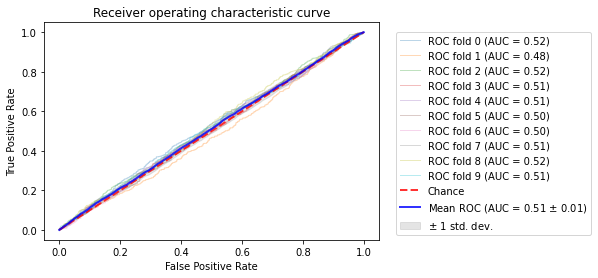

Kfold train F1
--------------

mean f1: 0.458, sigma f1: 0.003, 95% conf: 0.452 - 0.464

Kfold validation F1
--------------

mean f1: 0.457, sigma f1: 0.006, 95% conf: 0.446 - 0.469


In [419]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree

clf = GaussianNB()
clf_kfold(X_train, y_train, clf)

### Garadient boosting

KFold - classification time: 48.07 sec




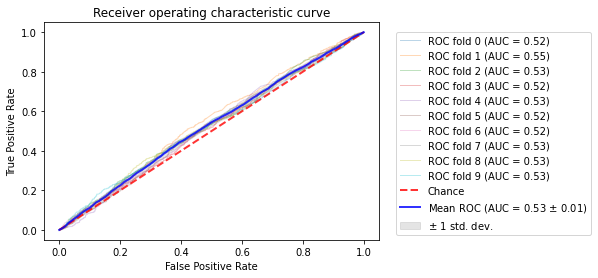

Kfold train F1
--------------

mean f1: 0.443, sigma f1: 0.002, 95% conf: 0.440 - 0.447

Kfold validation F1
--------------

mean f1: 0.439, sigma f1: 0.003, 95% conf: 0.432 - 0.446


In [420]:
from sklearn.ensemble import GradientBoostingClassifier

del clf
clf = GradientBoostingClassifier(max_depth=3)
clf_kfold(X_train, y_train, clf)

### SVM

KFold - classification time: 3.70 min




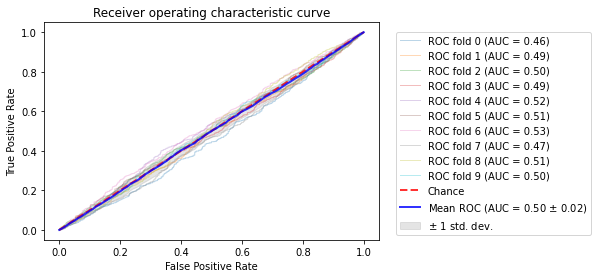

Kfold train F1
--------------

mean f1: 0.438, sigma f1: 0.000, 95% conf: 0.438 - 0.439

Kfold validation F1
--------------

mean f1: 0.438, sigma f1: 0.003, 95% conf: 0.432 - 0.445


In [425]:
from sklearn.svm import SVC

del clf
clf = SVC(C=1, gamma='auto')
clf_kfold(X_train, y_train, clf)

### Random forest 

Classification time: 9.89 sec




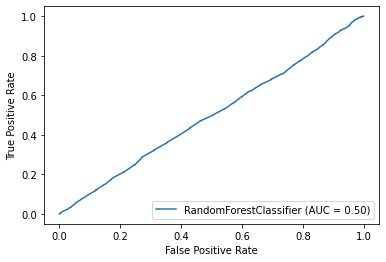

Evaluation F1 score: 0.98
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      5600
           1       0.99      1.00      0.99     19907

    accuracy                           0.99     25507
   macro avg       0.99      0.98      0.98     25507
weighted avg       0.99      0.99      0.99     25507

Test F1 score: 0.69
              precision    recall  f1-score   support

           0       0.29      0.03      0.05      1400
           1       0.78      0.98      0.87      4977

    accuracy                           0.77      6377
   macro avg       0.53      0.50      0.46      6377
weighted avg       0.67      0.77      0.69      6377



In [421]:
from sklearn.ensemble import RandomForestClassifier

del clf
clf = RandomForestClassifier(n_estimators=100, random_state=None) # ideal for non-linear data
start = time.time()
clf.fit(X_train, y_train)
ypred_eval = clf.predict(X_train)
end = time.time()
ypred = clf.predict(X_test)

print_stats(y_train, X_test, y_test, clf)

## Production test
Predict the class for the test dataset using the classifier with the best validation accurracy

In [422]:
# y_pred = best_clf.predict(X_test)

# f1_score = metrics.f1_score(y_test, y_pred, average='macro')
# print('F1 score: {:.2f}'.format(f1_score))
# print(classification_report(y_test, y_pred))

# metrics.plot_roc_curve(best_clf, X_test, y_test)  
# plt.show()